In [0]:
#!!pip uninstall tensorflow
#!pip install tensorflow==2.1.0
#!pip install -U pandas-profiling

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
PROJECT_DIR = "/content/drive/My Drive/MachineLearning/Capstone/"
DATA_FILE_NAME = 'Data/Input Data Synthetic.xlsx'
CLEANSED_FILE_NAME = 'Data/cleansed_data.csv'

In [6]:
#import basic libraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
#nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
pd.set_option('display.max_colwidth', 0)

##**1. Data Loading**

In [8]:
data_df = pd.read_excel(PROJECT_DIR+DATA_FILE_NAME, lines=True)
data_df.head(20)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,spxjnwir pjlcoqds,GRP_0
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0
6,event: critical:HostName_221.company.com the value of mountpoint threshold for /oracle/SID_37/erpdata21/,"event: critical:HostName_221.company.com the value of mountpoint threshold for /oracle/SID_37/erpdata21/sr3psa1d_7/sr3psa1d.data7,perpsr3psa1d,4524 is 98",jyoqwxhz clhxsoqy,GRP_1
7,ticket_no1550391- employment status - new non-employee [enter user's name],ticket_no1550391- employment status - new non-employee [enter user's name],eqzibjhw ymebpoih,GRP_0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0


In [9]:
data_df.shape

(8500, 4)

In [10]:
data_df.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


In [11]:
data_df[data_df.Description.isnull()]

,Short description,Description,Caller,Assignment group
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [0]:
#Replace space in column names with '_' and to lower case for better naming conversion
data_df.columns = [c.replace(' ', '_') for c in data_df.columns]
data_df.columns = [c.lower() for c in data_df.columns]

Inference:
1. There are total of 8500 datasets spread across 4 dimensions.
2. As we are classifing the ticket to category based on description, caller column is of no information to us. This can be removed in the pre-processing.
3. Though there are short description & description, we will classify based on description as it provides more details on the isssue.
4. From describe, we can notice that there are unique values on the description is 7817 out of 8500. This signifies there might be some duplicates in the decription.
5. There is 1 missing value in the description which can be replaced with short description of the same.
6. There are 74 unique categories to which the tickets are classified to.
7. There seems to be lot of cleanup required in the description column.

  a. There are os related new line and line termination tags.

  b. Few description have header - received from : - which doesn't provide much information on classification.

  c. Few description also have footer note - Thanks/regards followed by name - which doesn't provide much information on classification.
  
  d. There are few encoded words in description which could be name of the persons that are encrypted owing to PII governance which needs to be handled in pre-processing.
  
  e. There are also few system drive path, software versioning number and ip addresses.

  f. Some description might have attached with evidence photos which resulted in cid: tages in the description footer.







## **2. Exploratory Data Anlysis :**

### **2.1 Pre-Requisite**

In [0]:
#create a working copyy from the original dataframe
desc_df = data_df.copy(deep=True)

#Drop caller as it is not utilized in problem classification
desc_df = desc_df.drop(['caller'], axis=1)

In [14]:
desc_df.head(5)

,short_description,description,assignment_group
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,GRP_0
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


### **2.2 Target Category Analysis**

In [15]:
#category_df = pd.DataFrame(data = desc_df.assignment_group.value_counts())
pd.set_option('display.max_rows', desc_df.shape[0]+1)
pd.DataFrame(data = desc_df.assignment_group.value_counts())
#category_df.head(100)

,assignment_group
GRP_0,3976
GRP_8,661
GRP_24,289
GRP_12,257
GRP_9,252
GRP_2,241
GRP_19,215
GRP_3,200
GRP_6,184
GRP_13,145


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]), <a list of 10 Text major ticklabel objects>)

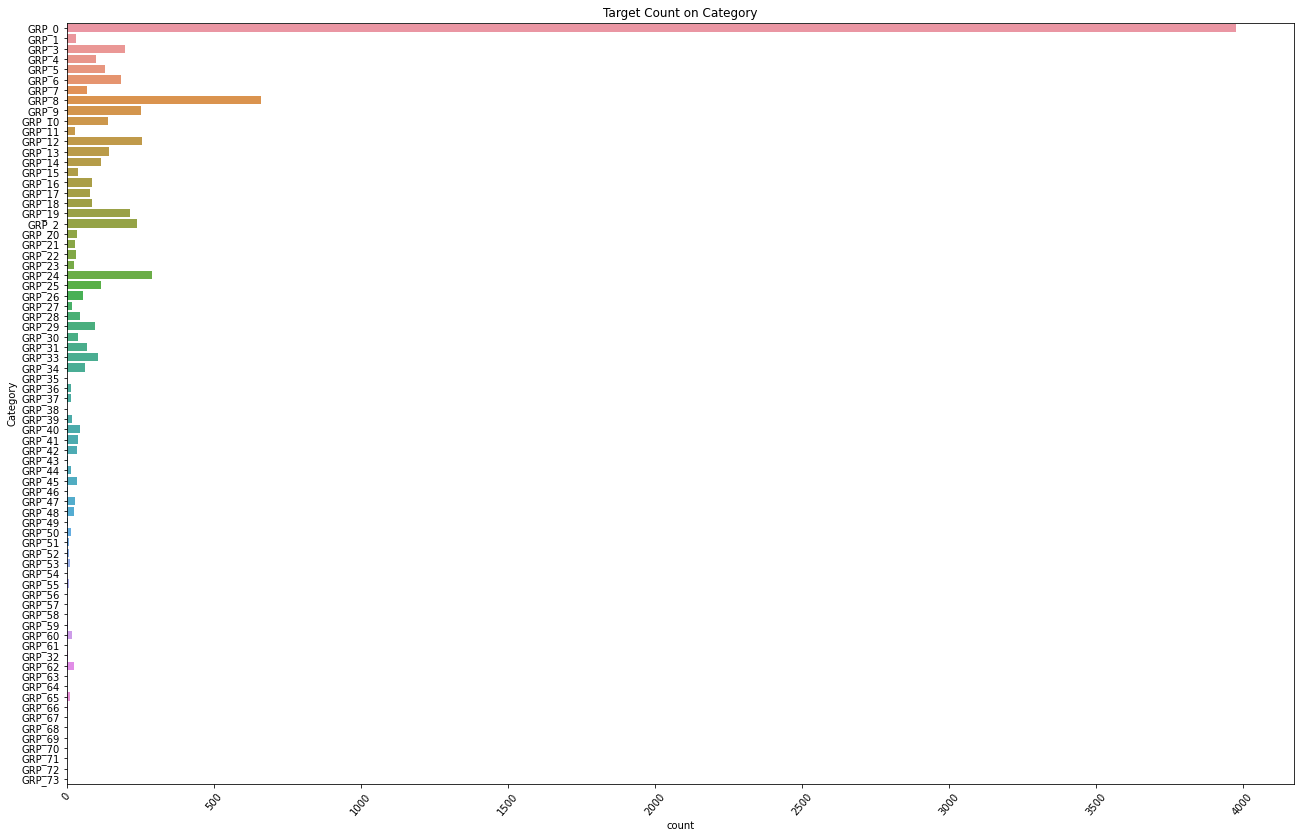

In [16]:
plt.figure(figsize=(22, 14))
sns.countplot(y=desc_df["assignment_group"])
plt.ylabel('Category')
plt.title('Target Count on Category')
plt.xticks(rotation=50)

In [17]:
#list the description which are less than 5 groupiing
temp_df = desc_df.groupby('assignment_group').filter(lambda x: len(x) < 6)
temp_df.describe()

,short_description,description,assignment_group
count,44,44,44
unique,44,43,19
top,update cutview to lauacyltoe hxgaycze version,update cutview to lauacyltoe hxgaycze version and adjust to current ms office installation,GRP_43
freq,1,2,5


In [0]:
#desc_df['assignment_group'] = 'GRP_COMMON' 
desc_df['assignment_group'] = desc_df.assignment_group.apply(lambda v: 'GRP_COMMON' if (desc_df.assignment_group.value_counts() < 6)[v] else v)

In [19]:
pd.set_option('display.max_rows', desc_df.shape[0]+1)
pd.DataFrame(data = desc_df.assignment_group.value_counts())

,assignment_group
GRP_0,3976
GRP_8,661
GRP_24,289
GRP_12,257
GRP_9,252
GRP_2,241
GRP_19,215
GRP_3,200
GRP_6,184
GRP_13,145


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]), <a list of 10 Text major ticklabel objects>)

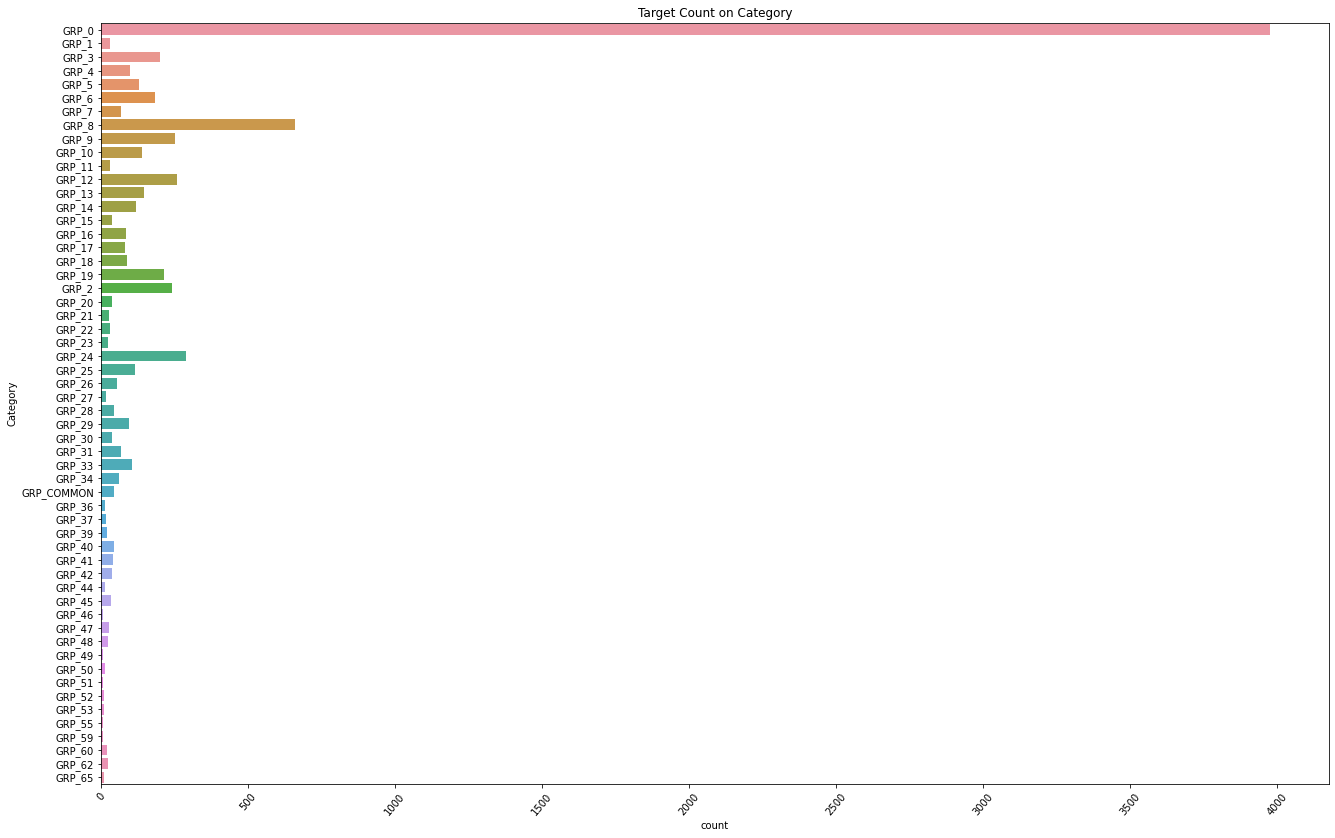

In [20]:
plt.figure(figsize=(22, 14))
sns.countplot(y=desc_df["assignment_group"])
plt.ylabel('Category')
plt.title('Target Count on Category')
plt.xticks(rotation=50)

Inference:

### **2.3 Feature Analysis:**

#### **2.3.1 Basic Analysis**

In [0]:
#create a working copy of data set
working_desc_df = desc_df.copy(deep=True)

In [0]:
#working_desc_df = working_desc_df.drop(['assignment_group'], axis=1)

In [23]:
#check for null/NaN in the description
working_desc_df[working_desc_df.description.isnull()]

,short_description,description,assignment_group
4395,i am locked out of skype,NaN,GRP_0


In [0]:
#Replace empty description with that short description
working_desc_df.description.fillna(working_desc_df.short_description, inplace=True)

In [25]:
#recheck for null/NaN inn\ the description
working_desc_df[working_desc_df.description.isnull()]

,short_description,description,assignment_group


In [26]:
# find duplicate decription column
desc_duplicate_df = working_desc_df[working_desc_df.duplicated(['description'],keep=False)].sort_values('description')
print('Number of duplicate rows (inclusive) : ', desc_duplicate_df.shape[0])
desc_duplicate_df.head(50)

Number of duplicate rows (inclusive) :  879


,short_description,description,assignment_group
3750,user jeshyensky can't log into accounts,"\n\nreceived from: gkzedilm.tkpfumeb@gmail.com\n\nuser gkzedilm tkpfumeb [jesjnlyenm] can't log into his aplications - engineering_tool and netweaver.\nnetweaver reports ""too many incorrect logins"" and engineering_engineering_tools ""unable to contact server"".\ni suspect the user is blocked from these accounts due to too many incorrect logins.\nthe user did not recently changed password.\n",GRP_0
3747,canadian customer inwarehouse_tools are not printing the tax amount on the inwarehouse_tools,"\n\nreceived from: gkzedilm.tkpfumeb@gmail.com\n\nuser gkzedilm tkpfumeb [jesjnlyenm] can't log into his aplications - engineering_tool and netweaver.\nnetweaver reports ""too many incorrect logins"" and engineering_engineering_tools ""unable to contact server"".\ni suspect the user is blocked from these accounts due to too many incorrect logins.\nthe user did not recently changed password.\n",GRP_13
5563,please assist erp log on need to be reset. not sure why but cant log on.,\n\nreceived from: gvderpbx.udrzjxkm@gmail.com\n\ngvderpbx udrzjxkm\njunior application sales engineer\ngvderpbx.udrzjxkm@gmail.com<mailto:gvderpbx.udrzjxkm@gmail.com>\n,GRP_0
4624,"please reset my erp pasword, battel to log in-username bragtydlc, thanks",\n\nreceived from: gvderpbx.udrzjxkm@gmail.com\n\ngvderpbx udrzjxkm\njunior application sales engineer\ngvderpbx.udrzjxkm@gmail.com<mailto:gvderpbx.udrzjxkm@gmail.com>\n,GRP_0
6722,request to reset microsoft online services password for aedzqlvj.mkosyxgh@gmail.com,"\r\n\r\nfrom: nwfodmhc exurcwkm \r\nsent: monday, august 22, 2016 3:21 pm\r\nto: bmhxwvys tdmgolwn\r\ncc: tiyhum kuyiomar\r\nsubject: re: sabrthy request to reset microsoft online services password for bmhxwvys.tdmgolwn@gmail.com\r\n\r\nhi suhrhtyju,\r\n\r\nplease reset your password in \r\n\r\n\r\n",GRP_34
6725,request to reset microsoft online services password for bmhxwvys.tdmgolwn@gmail.com,"\r\n\r\nfrom: nwfodmhc exurcwkm \r\nsent: monday, august 22, 2016 3:21 pm\r\nto: bmhxwvys tdmgolwn\r\ncc: tiyhum kuyiomar\r\nsubject: re: sabrthy request to reset microsoft online services password for bmhxwvys.tdmgolwn@gmail.com\r\n\r\nhi suhrhtyju,\r\n\r\nplease reset your password in \r\n\r\n\r\n",GRP_0
1300,cannot review stock at mdw04 // mm 6720004,"\r\n\r\nreceived from: aqrhwjgo.cyelqkvs@gmail.com\r\n\r\ndear it team,\r\n\r\ni just complete gr for dn 9168073012_mm 6720004 but there is not stock available on md04. please advise because i would like to ship to customer 5 pcs today.\r\n\r\n[cid:image001.png@01d22863.386174b0]\r\n\r\nbest",GRP_6
1301,cannot review stock at mdw04 // mm 6720004,"\r\n\r\nreceived from: aqrhwjgo.cyelqkvs@gmail.com\r\n\r\ndear it team,\r\n\r\ni just complete gr for dn 9168073012_mm 6720004 but there is not stock available on md04. please advise because i would like to ship to customer 5 pcs today.\r\n\r\n[cid:image001.png@01d22863.386174b0]\r\n\r\nbest",GRP_0
3647,ç­”å¤: ç­”å¤: order products online problem,"\r\n\r\nreceived from: fkdazsmi.yecbrofv@gmail.com\r\n\r\nhello,\r\ni will ask your help if i can't solve it with the help of my boss tomorrow.",GRP_0
3645,ç­”å¤: ç­”å¤: order products online problem,"\r\n\r\nreceived from: fkdazsmi.yecbrofv@gmail.com\r\n\r\nhello,\r\ni will ask your help if i can't solve it with the help of my boss tomorrow.",GRP_0


In [27]:
working_desc_df.shape

(8500, 3)

In [0]:
# drop duplicate decription rows
working_desc_df.drop_duplicates('description', inplace = True)

In [29]:
working_desc_df.shape

(7818, 3)

In [30]:
#ticket where short desc is greater than description
tmp_short_desc_length_df = working_desc_df[working_desc_df.short_description.str.len() > working_desc_df.description.str.len()]
tmp_short_desc_length_df.shape

(276, 3)

In [0]:
def description_length_compare(x,y):
  if ((x is not np.nan) and (len(x) > len(y))):
    return x
  else:
    return y

In [32]:
working_desc_df['description'] = working_desc_df.apply(lambda x: description_length_compare(x.short_description, x.description), axis=1)
working_desc_df.head()

,short_description,description,assignment_group
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,GRP_0
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


In [33]:
tmp_short_desc_length_df = working_desc_df[working_desc_df.short_description.str.len() > working_desc_df.description.str.len()]
tmp_short_desc_length_df.shape

(0, 3)

In [0]:
#to get words and their count in the dataset
def tokenize_counter(data):
  words_bow_series = data.str.split(expand=True).unstack().value_counts()
  words_bow_df = pd.DataFrame({'words':words_bow_series.index, 'count':words_bow_series.values})
  return words_bow_df;

In [0]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#method to create the n-gram from the corpus along with frequency of occurance
def get_top_n_ngram(corpus, ngram_range = (1,1), top=None, vectorizer = 'count'):
    if(vectorizer.lower() == 'tfidf'):
      vec = TfidfVectorizer(ngram_range=ngram_range).fit(corpus)
    else :
      vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    ngram_df = pd.DataFrame(words_freq[:top], columns = ['words' , 'freq'])
    return ngram_df

In [0]:
#bar plot for word cound plotting
def word_count_plot(xData, yData, numofwords, sort = 'asc'):
  if sort == 'asc':
    start = 0
    end = numofwords
  else:
    end = len(yData)
    start = end - numofwords

  trace = sns.barplot(
      y=yData.iloc[start:end],
      x=xData.iloc[start:end])
  return trace

In [0]:
#word cloud implementation to understannd word importance and frequency
from wordcloud import WordCloud
def generate_wordcloud(corpus_df, stopwords='', mask=None, max_words=100, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=24, image_color=False, ):

  wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=600,collocations = False,
                    mask = mask).generate_from_frequencies(dict(corpus_df))
  return wordcloud

#### **2.3.2 Before Cleaning**

In [38]:
desc_bow_df = get_top_n_ngram(working_desc_df['description'])
print('Length of tokens : ', len(desc_bow_df))

Length of tokens :  22154


In [39]:
desc_bow_df

,words,freq
0,to,6248
1,the,6081
2,com,3632
3,in,3325
4,from,3260
...,...,...
22149,drawers,1
22150,adjustment,1
22151,mehreren,1
22152,verschiedene,1


In [0]:
desc_wordcloud = generate_wordcloud(desc_bow_df.values.tolist())

(-0.5, 799.5, 599.5, -0.5)

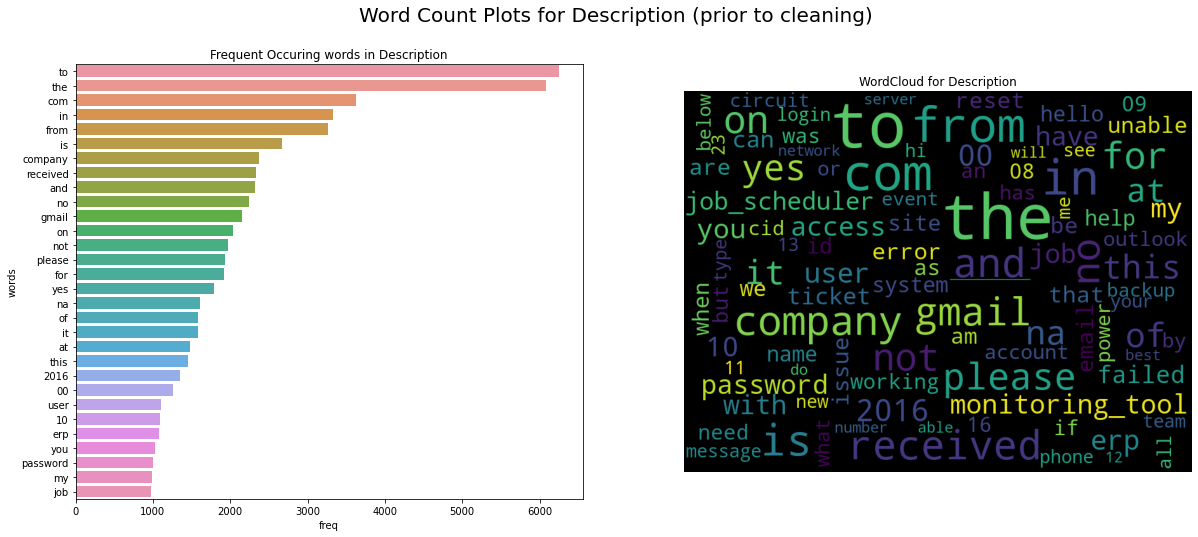

In [41]:
plt.figure(figsize=(20, 8))
plt.suptitle('Word Count Plots for Description (prior to cleaning)',fontsize=20)
plt.subplot(1, 2, 1)
plt.title('Frequent Occuring words in Description')
word_count_plot(desc_bow_df['freq'], desc_bow_df['words'], 30, 'asc')
plt.subplot(1, 2, 2)
plt.title('WordCloud for Description')
plt.imshow(desc_wordcloud)
plt.axis("off")

Combine above steps into single method defination for re-use.

In [0]:
#method to plot frequency & wordcloud
def plot_count_cloud_graph(wordcount, wordcloud, title):
  plt.figure(figsize=(20, 8))
  plt.suptitle(title,fontsize=20)
  plt.subplot(1, 2, 1)
  plt.title('Frequent Occuring words in Description')
  word_count_plot(wordcount['freq'], wordcount['words'], 30, 'asc')
  plt.subplot(1, 2, 2)
  plt.title('WordCloud for Description')
  plt.imshow(desc_wordcloud)
  plt.axis("off")

In [0]:
#method to generate bow & wordcloud
def generate_bow_wordcloud(text):
  bow_df = get_top_n_ngram(text)
  wordcloud = generate_wordcloud(bow_df.values.tolist())
  return bow_df, wordcloud

In [0]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['description'])
#desc_bow_df = generate_bow_wordcloud(working_desc_df['description'])
#desc_bow_df

Vocabulary Size : 22154 



,short_description,description,assignment_group
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,GRP_0
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


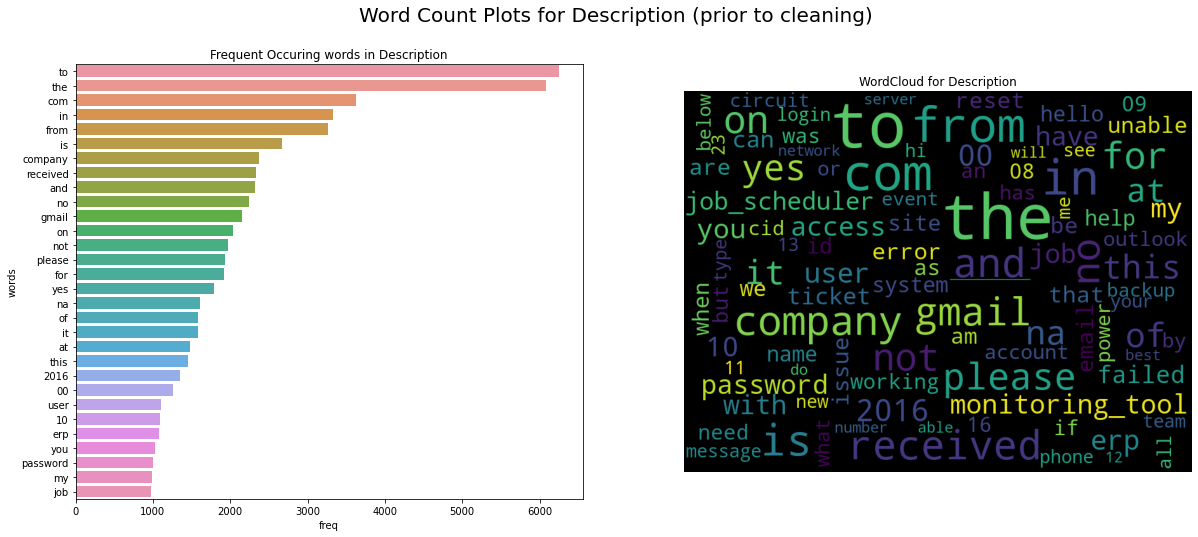

In [45]:
##to print vocal size from Bag Of Words created
print('Vocabulary Size : {} \n'.format(len(desc_bow_df)))
#plot the frequency $ cloud plot
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description (prior to cleaning)')
#print top 5 description
working_desc_df.head()

Inference:
1. Notice too many common words like - the, to, in, is - exists.
2. Notice the existance of special characeters - ?, monitoring_tool@company.com - the dataset

Lets do carry some pre processing on the data to clean up

#### **2.3.3 Data Cleaning Analysis**

Pre-Processing
1. Remove excape characters - new line
2. Remove received from header & footer tags
2. Remove the image attachment reference in footer
4. Remove any email id reference
4. Remove Punctuation
6. Remove stop words
7. Check frequent words with respect to problem context


In [0]:
#remove os line break tags
def remove_line_break(text):
  text = str(text)
  data = text.replace('\r\n', '\n')
  data = data.replace('\r', '\n')
  return data

In [0]:
#remove some header and footers in the descriptionn
def remove_exclusion_text(text, exclusionText, line_breaker):
  #print('data : ', data)
  data = [line for line in text.split(line_breaker) if not exclusionText in line]
  return line_breaker.join(data)

In [0]:
def clean_text(text, exclusionTagList):
  data = remove_line_break(text)
  for excl_txt in exclusionTagList:
    data = remove_exclusion_text(data, excl_txt, '\n')
  data = " ".join([word for word in text.split('\n')])
  return data

In [0]:
#word starting with following tags can be excluded as they dont difine problem statement
exclusion_text_tags = ['received from', 'cid:image', 'importance:', 
                       'email:','subject:','to:', 'sent:', 'from:', 
                       'approved by', ' user id :','name :','mailto:', '(yes/no/na)']

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags))

Vocabulary Size : 22154 



0    -verified user details.(employee# & manager name)\r -checked the user name in ad and reset the password.\r -advised the user to login and check.\r -caller confirmed that he was able to login.\r -issue resolved.
1    \r \r received from: hmjdrvpb.komuaywn@gmail.com\r \r hello team,\r \r my meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r \r kind         
2    \r \r received from: eylqgodm.ybqkwiam@gmail.com\r \r hi\r \r i cannot log on to vpn\r \r best                                                                                                                    
3    unable to access hr_tool page                                                                                                                                                                                     
4    skype error                                                                                                                        

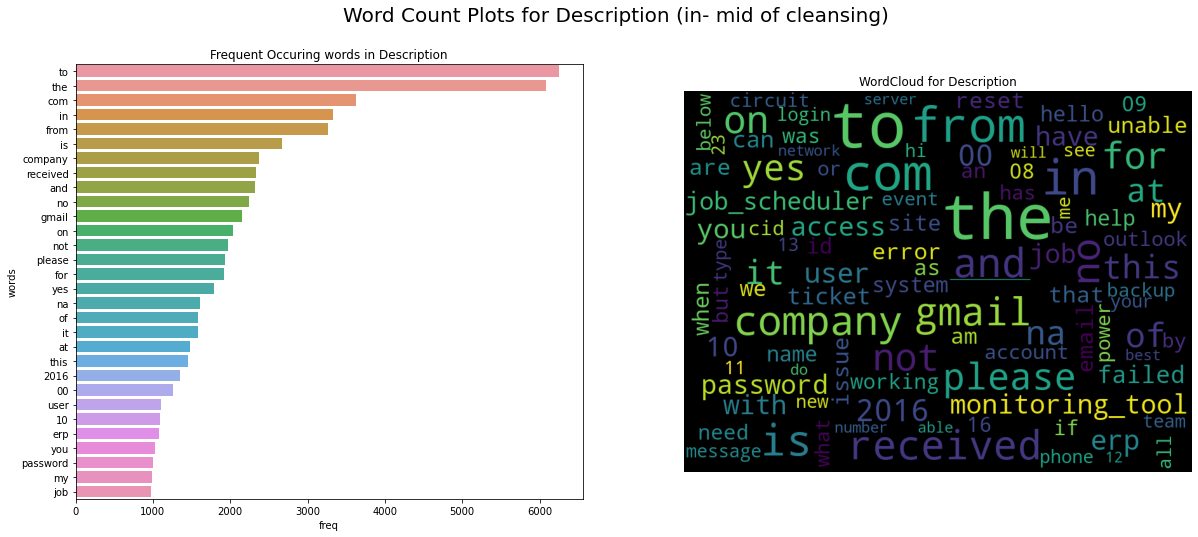

In [51]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['cleansed_desc'])
#to print vocal size from Bag Of Words created
print('Vocabulary Size : {} \n'.format(len(desc_bow_df)))
#plot the frequency $ cloud plot
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description (in- mid of cleansing)')
#print top 5 description
working_desc_df['cleansed_desc'].head()


In [0]:
#method to convert text to lowercase
def to_lower (text):
  return text.lower()

In [0]:
#remove some header and footers in the descriptionn
import re
def remove_email(text):
  re_mail = re.compile('\S+@+\S+.?')
  data = [re_mail.sub(' ', word) for word in text.split()]
  return ' '.join(data)

In [0]:
def remove_underscore(text):
  text = text.replace("'",'')
  data = []
  for word in text.split():
    if('job_' in word):
      data.append(word)
    else:
      data.append(word.replace('_', ' '))    
  return ' '.join(data)

In [0]:
#replace punctutions with white space
def remove_punctuation(text):
    punctuation = string.punctuation
    punctuation = punctuation.replace('_','') #elimanate underscore
    return text.translate(str.maketrans(punctuation, ' '*len(punctuation)))

In [0]:
def clean_text(text, exclusionTagList):
  data = remove_line_break(text)
  for excl_txt in exclusionTagList:
    data = remove_exclusion_text(data, excl_txt, '\n')
  data = " ".join([word for word in text.split('\n')])
  data = to_lower(data)
  data = remove_email(data)
  data = remove_underscore(data)
  data = remove_punctuation(data)
  return data

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags))

Vocabulary Size : 19329 



0     verified user details  employee    manager name   checked the user name in ad and reset the password   advised the user to login and check   caller confirmed that he was able to login   issue resolved 
1    received from  hello team  my meetings skype meetings etc are not appearing in my outlook calendar  can somebody please advise how to correct this  kind                                                  
2    received from  hi i cannot log on to vpn best                                                                                                                                                             
3    unable to access hr tool page                                                                                                                                                                             
4    skype error                                                                                                                                                        

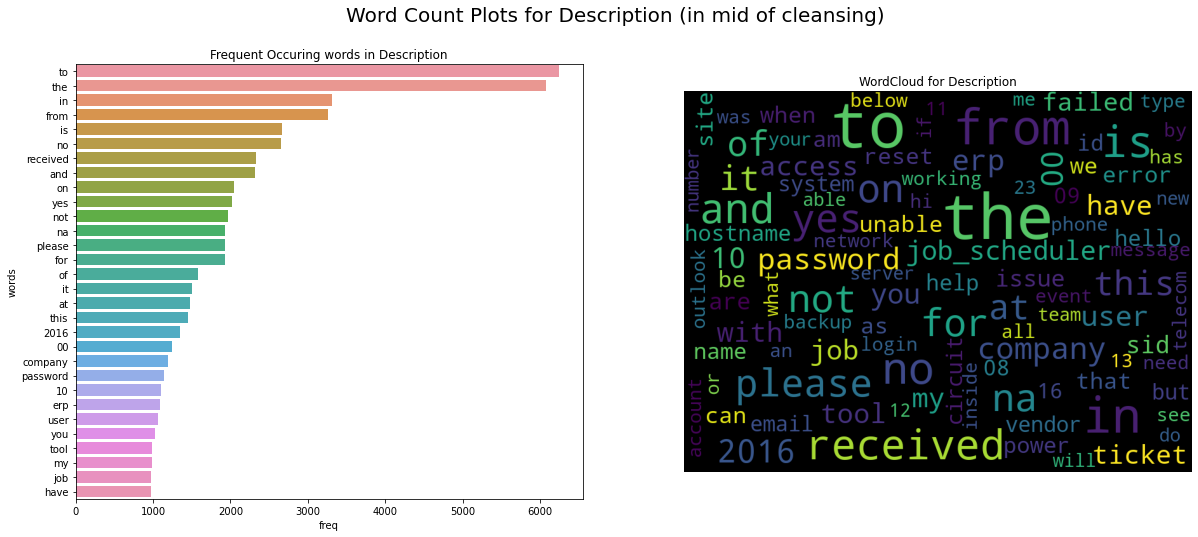

In [58]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['cleansed_desc'])
#to print vocal size from Bag Of Words created
print('Vocabulary Size : {} \n'.format(len(desc_bow_df)))
#plot the frequency $ cloud plot
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description (in mid of cleansing)')
#print top 5 description
working_desc_df['cleansed_desc'].head()


In [0]:
#strip more than 1 leading or trailing white spaces
def strip_addl_whitespace(text):
    return " ".join([word for word in text.split() if word.strip()])

In [0]:
# remove any numbers in the dataset
def remove_non_alpha(text):
  return " ".join([word for word in text.split() if word.isalpha()])

# remove any numbers in the dataset
def remove_digits(text):
  #re_digits = re.compile(" \d+")
  #data = [re_digits.sub(' ', word) for word in text.split()]
  #return " ".join(data)
  return " ".join([word for word in text.split() if not word.isdigit()])

In [0]:
def clean_text(text, exclusionTagList):
  data = remove_line_break(text)
  #print(data)
  for excl_txt in exclusionTagList:
    data = remove_exclusion_text(data, excl_txt, '\n')
  data = " ".join([word for word in text.split('\n')])
  data = to_lower(data)
  data = remove_email(data)
  data = remove_underscore(data)
  data = remove_punctuation(data)
  data = strip_addl_whitespace(data)
  data = remove_digits(data)
  return data

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags))

Vocabulary Size : 16212 



0    verified user details employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved
1    received from hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind                                        
2    received from hi i cannot log on to vpn best                                                                                                                                                
3    unable to access hr tool page                                                                                                                                                               
4    skype error                                                                                                                                                                                 
Name: cleansed_desc, dtype: ob

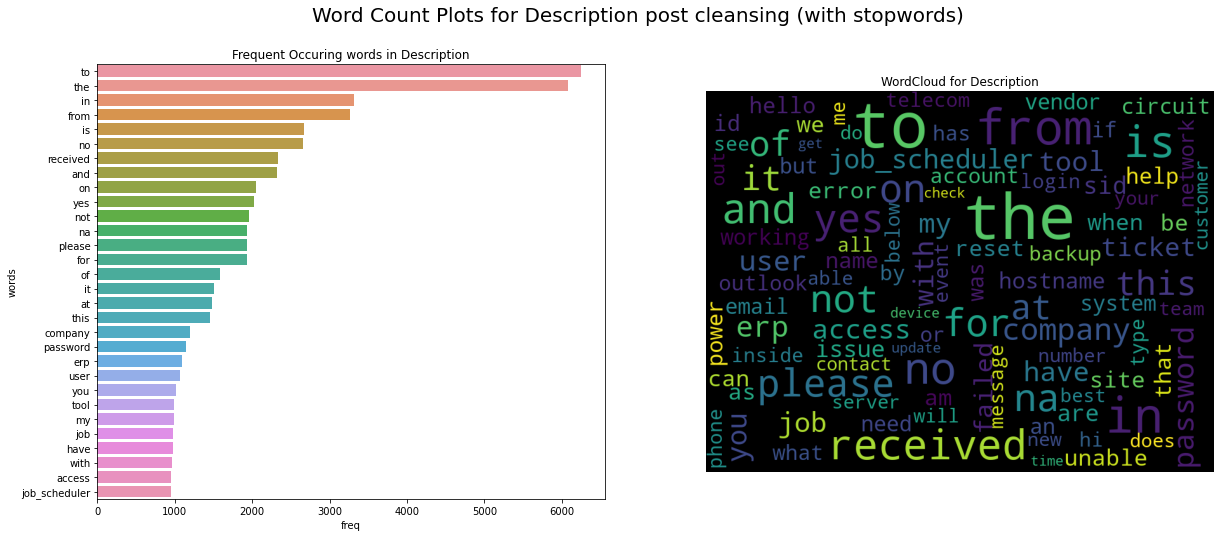

In [63]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['cleansed_desc'])
#to print vocal size from Bag Of Words created
print('Vocabulary Size : {} \n'.format(len(desc_bow_df)))
#plot the frequency $ cloud plot
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description post cleansing (with stopwords)')
#print top 5 description
working_desc_df['cleansed_desc'].head()


Stop Words:

In [64]:
#fetch stopwods from nltk lib
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#method to exclude the stopwords from the corpura and also generate exclude word cout
from collections import Counter
from collections import OrderedDict

removed_words=[]
def remove_stopwords(text, stopwords):
  global removed_words
  #global removed_words_counter 
  global removed_words_df
  data = []
  for word in text.split():
    if not word in stopwords:
      data.append(word)
    else:
      removed_words.append(word)
  removed_words_counter = Counter(removed_words)
  removed_words_counter = OrderedDict(sorted(removed_words_counter.items(), key = lambda x: x[1], reverse=True))
  removed_words_df = pd.DataFrame(removed_words_counter.items(),columns=['words','count'])
  return ' '.join(data)

In [0]:
def clean_text(text, exclusionTagList, stop_words=None):
  data = str(text)
  data = remove_line_break(data)
  for excl_txt in exclusionTagList:
    data = remove_exclusion_text(data, excl_txt, '\n')
  data = to_lower(data)
  data = remove_email(data)
  data = remove_underscore(data)
  data = remove_punctuation(data)
  data = strip_addl_whitespace(data)
  data = remove_digits(data)
  data = remove_stopwords(data, stop_words)
  return data

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags, stop_words))

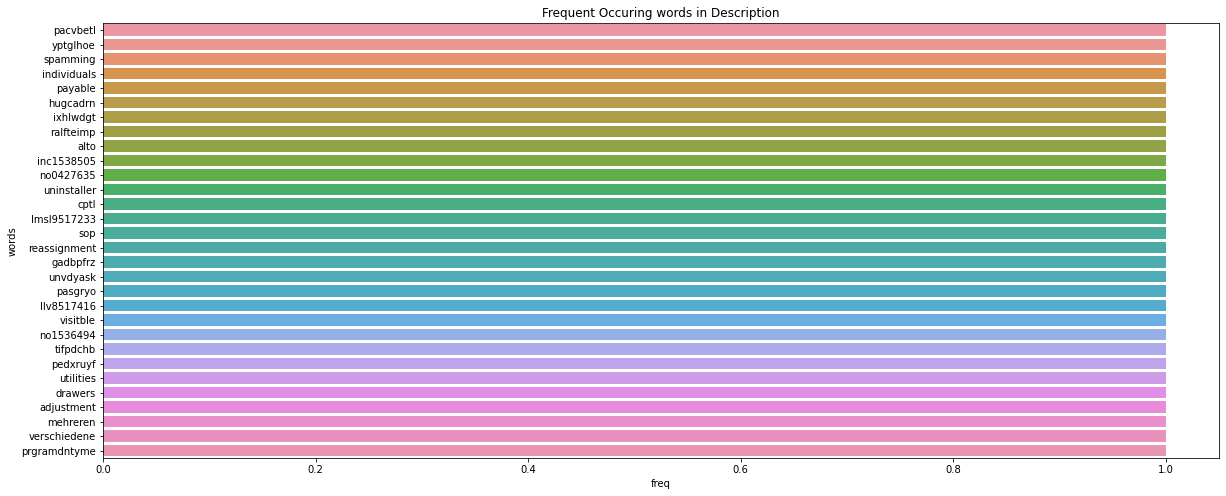

In [68]:
plt.figure(figsize=(20, 8))
plt.title('Frequent Occuring words in Description')
word_count_plot(desc_bow_df['freq'], desc_bow_df['words'], 30, 'desc')
  

Vocabulary Size :  15557


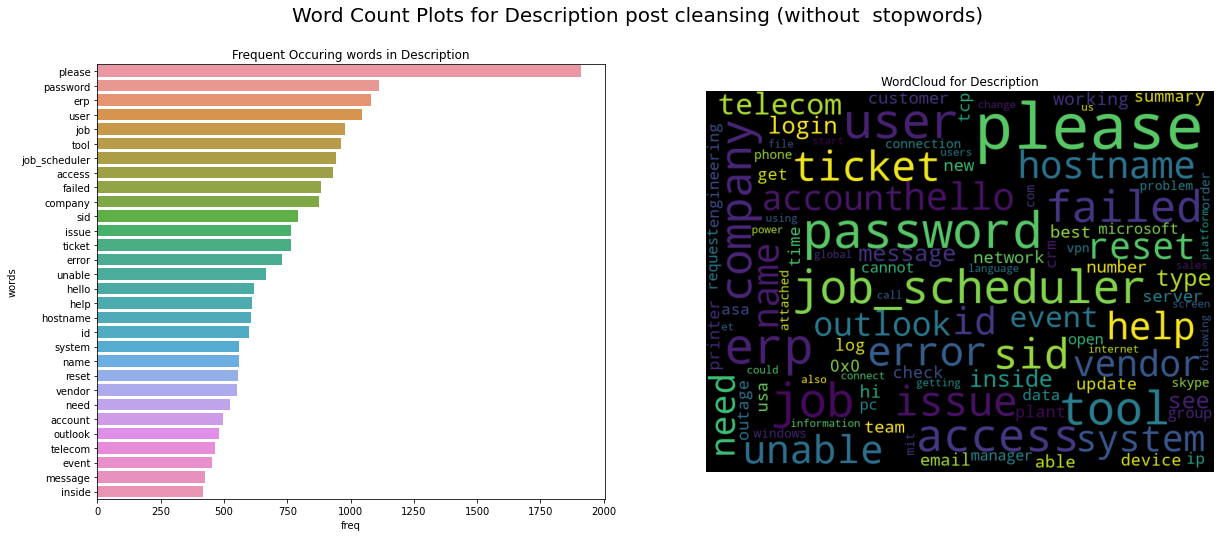

In [69]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['cleansed_desc'])
print('Vocabulary Size : ', len(desc_bow_df))
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description post cleansing (without  stopwords)')

Lets explore the removed words

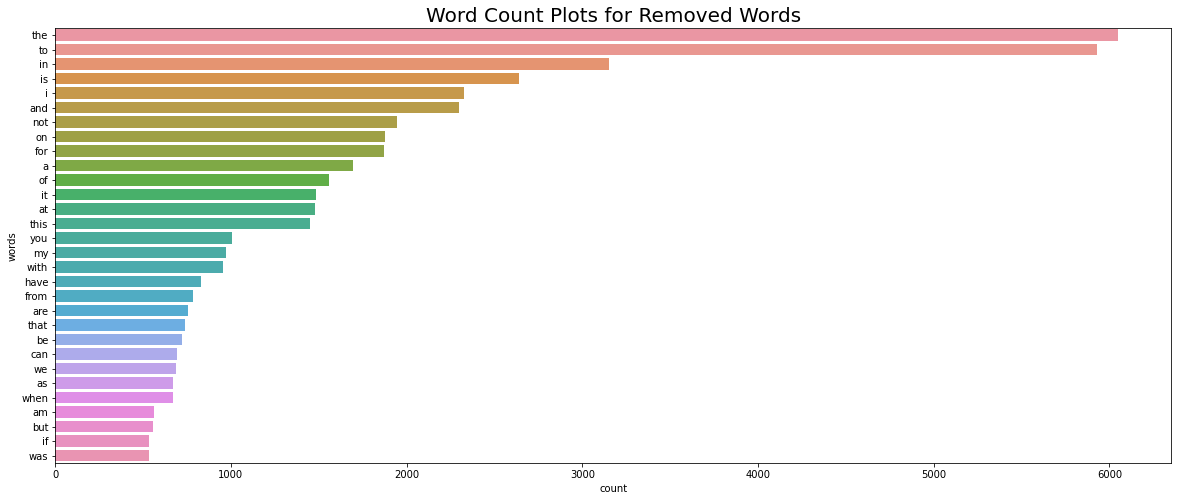

In [70]:
plt.figure(figsize=(20, 8))
plt.title('Word Count Plots for Removed Words',fontsize=20)
word_count_plot(removed_words_df['count'],removed_words_df['words'], 30, 'asc')

In [0]:
addl_stopwords = ['yes', 'please', 'hello', 'name','yes','best','kind'] #added
not_stopwords = ['not', 'no', 'nor'] #remove
#added caller name to stop words
caller_names = pd.DataFrame(data_df.caller.str.split().tolist()).stack().reset_index()[0].tolist()

In [0]:
#to add addl stop words to the nltk list
stop_words.extend(addl_stopwords)
stop_words.extend(caller_names)
#remove non stopwords from NLTK stopwords list
stop_words = [word for word in stop_words if word not in not_stopwords]

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags, stop_words))

Vocabulary Size :  14520


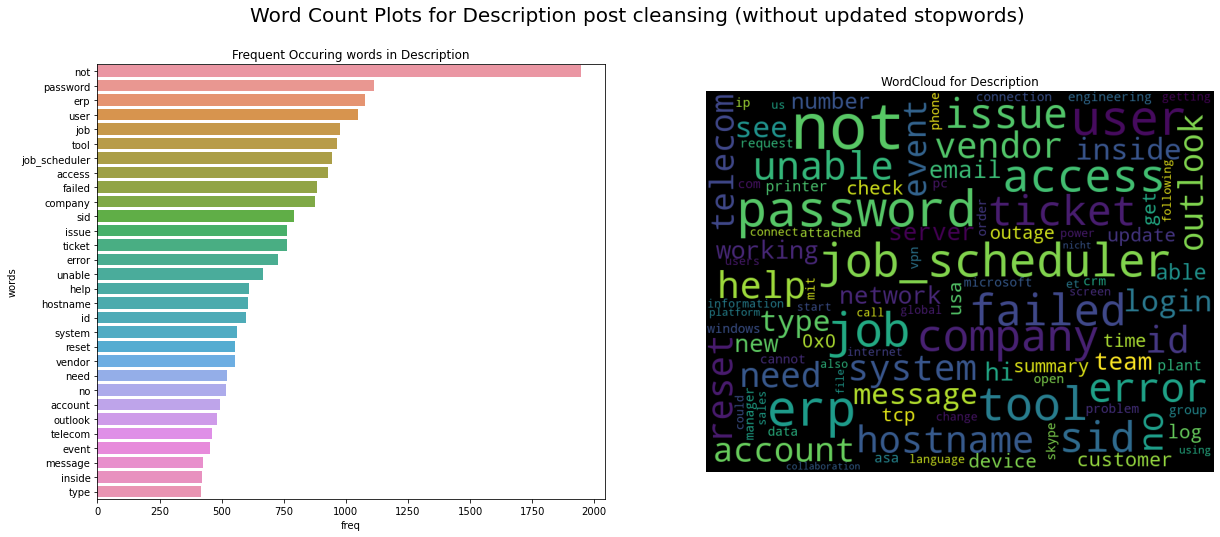

In [74]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['cleansed_desc'])
print('Vocabulary Size : ', len(desc_bow_df))
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description post cleansing (without updated stopwords)')

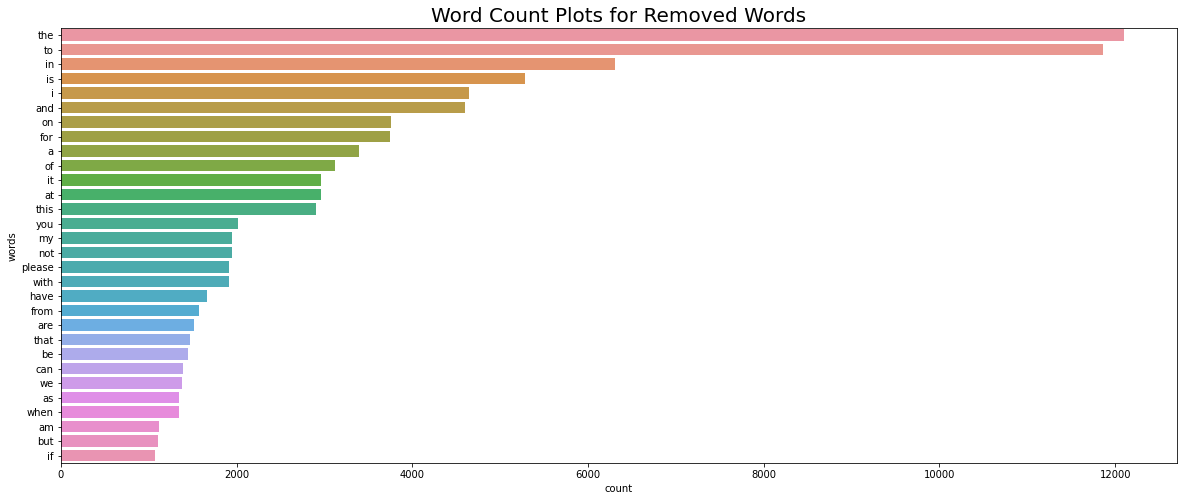

In [75]:
plt.figure(figsize=(20, 8))
plt.title('Word Count Plots for Removed Words',fontsize=20)
word_count_plot(removed_words_df['count'],removed_words_df['words'], 30, 'asc')

### **2.3.4 n-gram Analysis**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#method to create the n-gram from the corpus along with frequency of occurance
def get_top_n_ngram(corpus, ngram_range = (1,1), top=None, vectorizer = 'count'):
    if(vectorizer.lower() == 'tfidf'):
      vec = TfidfVectorizer(ngram_range=ngram_range).fit(corpus)
    else :
      vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)  
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    ngram_df = pd.DataFrame(words_freq[:top], columns = ['words' , 'freq'])
    return ngram_df

In [0]:
#word cloud implementation to understannd word importance and frequency
from wordcloud import WordCloud
def generate_wordcloud(corpus_df, stopwords='', mask=None, max_words=100, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=24, image_color=False, ):
 
  wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=600,collocations = False,
                    mask = mask).generate_from_frequencies(dict(corpus_df))
  return wordcloud

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags,[]))
working_desc_df['cleansed_desc_wo_stopwords'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags, stop_words))

In [0]:
#unigram_count_df = get_top_n_ngram(working_desc_df['cleansed_desc'],(1,1), 20, 'count')
#unigram_tfidf_df = get_top_n_ngram(working_desc_df['cleansed_desc'],(1,1), 20, 'count')
unigram_count_df_wo_stopwords = get_top_n_ngram(working_desc_df['cleansed_desc_wo_stopwords'],(1,1), None, 'count')
unigram_tfidf_df_wo_stopwords = get_top_n_ngram(working_desc_df['cleansed_desc_wo_stopwords'],(1,1), None, 'tfidf')

In [80]:
print('Total no of uni-grams from corpus - tfidf : ', unigram_tfidf_df_wo_stopwords.shape[0])
print('Total no of uni-grams from corpus - count : ', unigram_count_df_wo_stopwords.shape[0])

Total no of uni-grams from corpus - tfidf :  14520
Total no of uni-grams from corpus - count :  14520


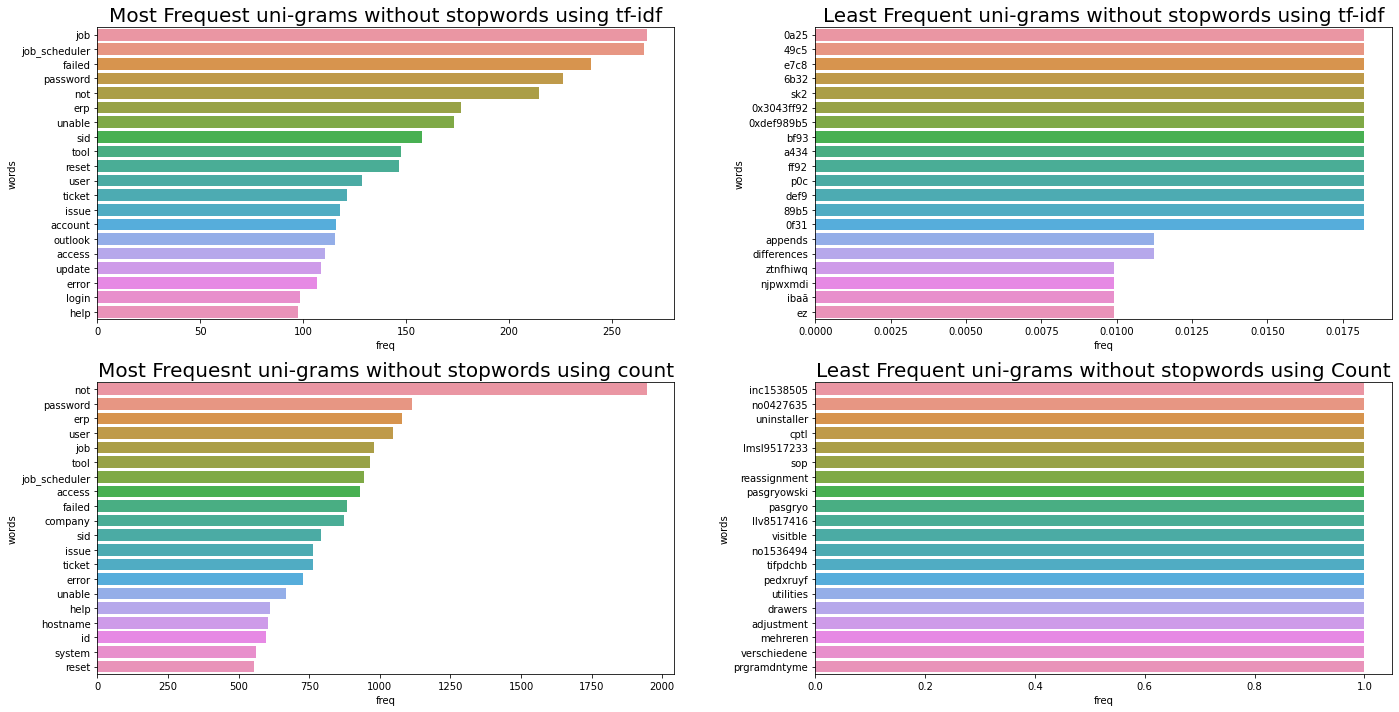

In [81]:
plt.figure(figsize=(20, 10))
#plt.suptitle('Word Count Plots for uni-grams',fontsize=20)
plt.subplot(2, 2, 1)
plt.title('Most Frequest uni-grams without stopwords using tf-idf',fontsize=20)
word_count_plot(unigram_tfidf_df_wo_stopwords['freq'],unigram_tfidf_df_wo_stopwords['words'], 20, 'asc')
plt.subplot(2, 2, 2)
plt.title('Least Frequent uni-grams without stopwords using tf-idf',fontsize=20)
word_count_plot(unigram_tfidf_df_wo_stopwords['freq'],unigram_tfidf_df_wo_stopwords['words'], 20, 'desc')
plt.subplot(2, 2, 3)
plt.title('Most Frequesnt uni-grams without stopwords using count',fontsize=20)
word_count_plot(unigram_count_df_wo_stopwords['freq'],unigram_count_df_wo_stopwords['words'], 20, 'asc')
plt.subplot(2, 2, 4)
plt.title('Least Frequent uni-grams without stopwords using Count',fontsize=20)
word_count_plot(unigram_count_df_wo_stopwords['freq'],unigram_count_df_wo_stopwords['words'], 20, 'desc')
plt.tight_layout()

In [0]:
bigram_count_df_wo_stopwords = get_top_n_ngram(working_desc_df['cleansed_desc_wo_stopwords'],(2,2), None, 'count')
bigram_tfidf_df_wo_stopwords = get_top_n_ngram(working_desc_df['cleansed_desc_wo_stopwords'],(2,2), None, 'tfidf')

In [83]:
print('Total no of bi-grams from corpus - tfidf : ', bigram_tfidf_df_wo_stopwords.shape[0])
print('Total no of bi-grams from corpus - count : ', bigram_count_df_wo_stopwords.shape[0])

Total no of bi-grams from corpus - tfidf :  61580
Total no of bi-grams from corpus - count :  61580


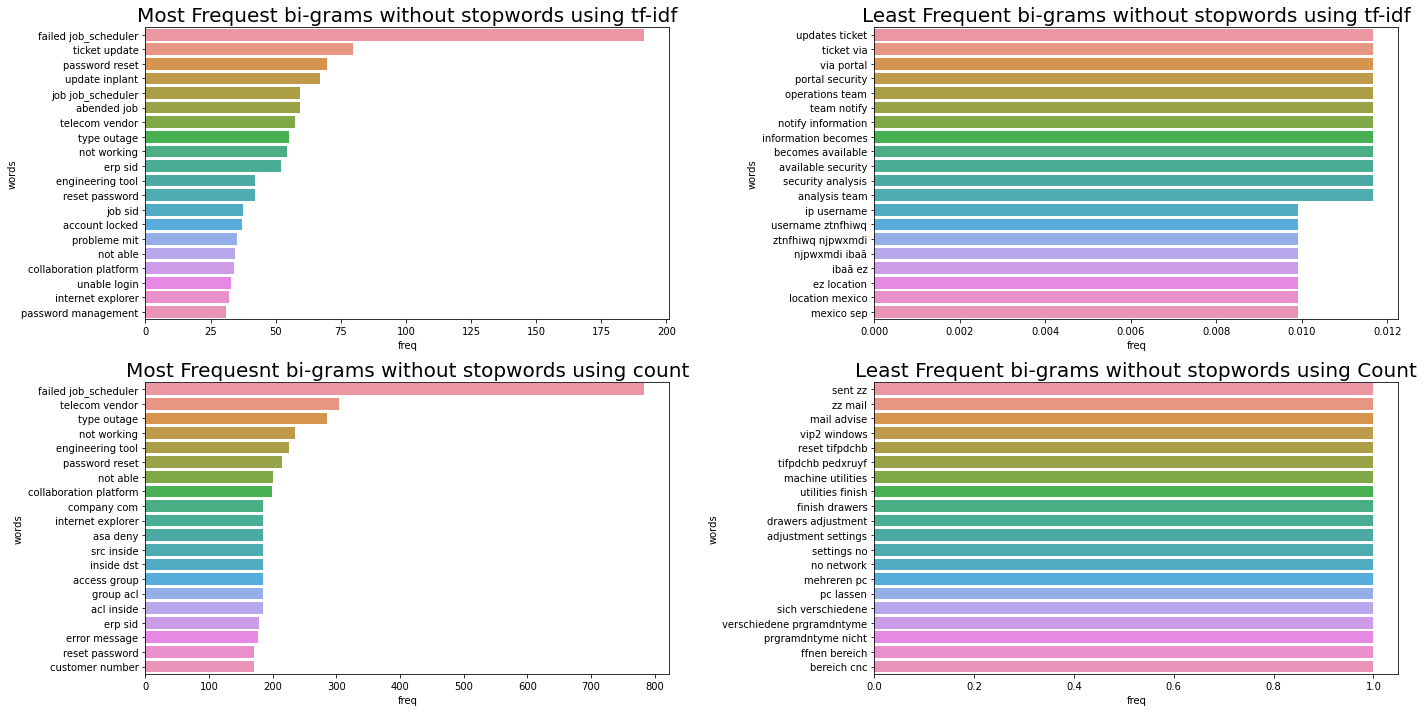

In [84]:
plt.figure(figsize=(20, 10))
#plt.suptitle('Word Count Plots for uni-grams',fontsize=20)
plt.subplot(2, 2, 1)
plt.title('Most Frequest bi-grams without stopwords using tf-idf',fontsize=20)
word_count_plot(bigram_tfidf_df_wo_stopwords['freq'],bigram_tfidf_df_wo_stopwords['words'], 20, 'asc')
plt.subplot(2, 2, 2)
plt.title('Least Frequent bi-grams without stopwords using tf-idf',fontsize=20)
word_count_plot(bigram_tfidf_df_wo_stopwords['freq'],bigram_tfidf_df_wo_stopwords['words'], 20, 'desc')
plt.subplot(2, 2, 3)
plt.title('Most Frequesnt bi-grams without stopwords using count',fontsize=20)
word_count_plot(bigram_count_df_wo_stopwords['freq'],bigram_count_df_wo_stopwords['words'], 20, 'asc')
plt.subplot(2, 2, 4)
plt.title('Least Frequent bi-grams without stopwords using Count',fontsize=20)
word_count_plot(bigram_count_df_wo_stopwords['freq'],bigram_count_df_wo_stopwords['words'], 20, 'desc')
plt.tight_layout()

In [0]:
trigram_count_df_wo_stopwords = get_top_n_ngram(working_desc_df['cleansed_desc_wo_stopwords'],(3,3), None, 'count')
trigram_tfidf_df_wo_stopwords = get_top_n_ngram(working_desc_df['cleansed_desc_wo_stopwords'],(3,3), None, 'tfidf')

In [86]:
print('Total no of tri-grams from corpus - tfidf : ', trigram_tfidf_df_wo_stopwords.shape[0])
print('Total no of tri-grams from corpus - count : ', trigram_count_df_wo_stopwords.shape[0])

Total no of tri-grams from corpus - tfidf :  75257
Total no of tri-grams from corpus - count :  75257


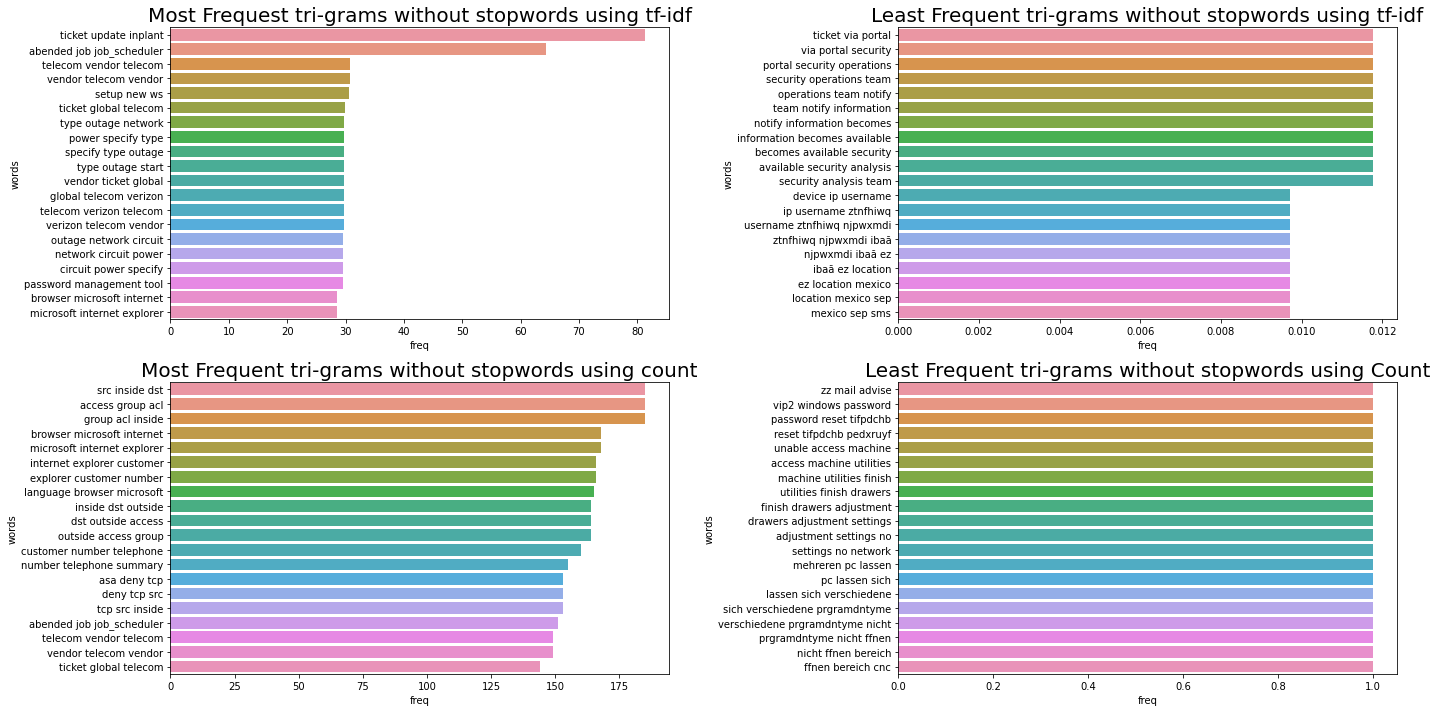

In [87]:
plt.figure(figsize=(20, 10))
#plt.suptitle('Word Count Plots for uni-grams',fontsize=20)
plt.subplot(2, 2, 1)
plt.title('Most Frequest tri-grams without stopwords using tf-idf',fontsize=20)
word_count_plot(trigram_tfidf_df_wo_stopwords['freq'],trigram_tfidf_df_wo_stopwords['words'], 20, 'asc')
plt.subplot(2, 2, 2)
plt.title('Least Frequent tri-grams without stopwords using tf-idf',fontsize=20)
word_count_plot(trigram_tfidf_df_wo_stopwords['freq'],trigram_tfidf_df_wo_stopwords['words'], 20, 'desc')
plt.subplot(2, 2, 3)
plt.title('Most Frequent tri-grams without stopwords using count',fontsize=20)
word_count_plot(trigram_count_df_wo_stopwords['freq'],trigram_count_df_wo_stopwords['words'], 20, 'asc')
plt.subplot(2, 2, 4)
plt.title('Least Frequent tri-grams without stopwords using Count',fontsize=20)
word_count_plot(trigram_count_df_wo_stopwords['freq'],trigram_count_df_wo_stopwords['words'], 20, 'desc')
plt.tight_layout()

In [0]:
#trigram_count_df_wo_stopwords

In [0]:
unigram_wordcloud = generate_wordcloud(unigram_count_df_wo_stopwords.values.tolist())
bigram_wordcloud = generate_wordcloud(bigram_count_df_wo_stopwords.values.tolist())
trigram_wordcloud = generate_wordcloud(trigram_count_df_wo_stopwords.values.tolist())

(-0.5, 799.5, 599.5, -0.5)

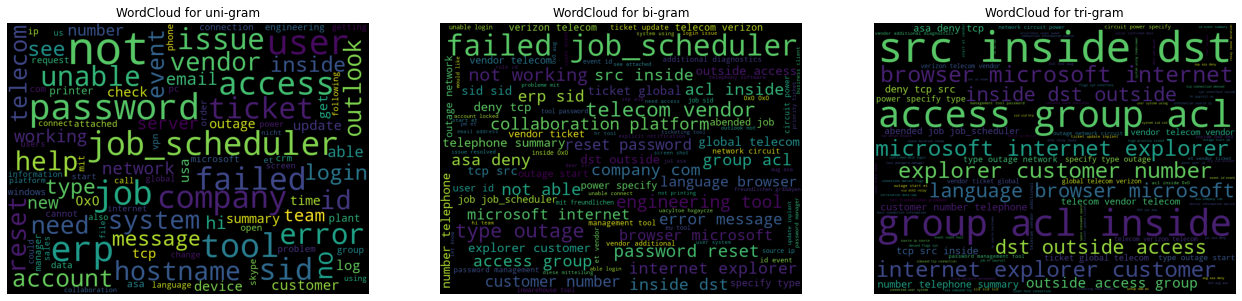

In [90]:
plt.figure(figsize=(22, 10))

plt.subplot(1, 3, 1)
plt.imshow(unigram_wordcloud)
plt.title('WordCloud for uni-gram')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(bigram_wordcloud)
plt.title('WordCloud for bi-gram')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(trigram_wordcloud)
plt.title('WordCloud for tri-gram')
plt.axis("off")

## **3. Pre-Processing**

1. Load document from directory
2. Null check on features
3. Cleansing the data as explained in EDA
4. Save back to directory


In [0]:
from sklearn.preprocessing import LabelEncoder

In [92]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [0]:
def load_doc(filename):
  if(filename.endswith('.xlsx')):
    data_df = pd.read_excel(filename, lines=True)
  elif(filename.endswith('.csv')):
    data_df = pd.read_csv(filename)
  return data_df

In [0]:
#remove os line break tags
def remove_line_break(text):
  text = str(text)
  #data = text.replace('\r\n', '\n')
  data = text.replace('\r', '')
  return data

#remove some header and footers in the descriptionn
def remove_exclusion_text(text, exclusionText, line_breaker):
  data = [line for line in text.split(line_breaker) if not exclusionText in line]
  return line_breaker.join(data)

#method to convert text to lowercase
def to_lower (text):
  return text.lower()

def clean_words(text):
  rem_mail = re.compile('\S+@+\S+.?')
  punctuation = string.punctuation.replace('_','')
  eng_words = set(nltk.corpus.words.words())
  rem_alphanum = re.compile(r'\D*\d')
  data = []
  for word in text.split():
    word = rem_mail.sub('', word)
    if('_' in word and'job_' not in word ):
      word = word.replace('_', ' ')
    word = word.replace("'",'')
    word = word.translate(str.maketrans(punctuation, ' '*len(punctuation)))
    word = word.strip()
    if (word in eng_words and word.isalpha() and len(word) > 1 
        and 'job_' not in word and not rem_alphanum.match(word) and not word.isdigit()):
      data.append(word)
  return ' '.join(data)  

#remove some header and footers in the descriptionn
import re
def remove_email(text):
  re_mail = re.compile('\S+@+\S+.?')
  data = [re_mail.sub('', word) for word in text.split()]
  return ' '.join(data)

def remove_underscore(text):
  text = text.replace("'",'')
  data = []
  for word in text.split():
    if('job_' in word):
      data.append(word)
    else:
      data.append(word.replace('_', ' '))    
  return ' '.join(data)

#replace punctutions with white space
def remove_punctuation(text):
    punctuation = string.punctuation.replace('_','')
    punctuation = punctuation.replace('_','')
    punctuation = punctuation.replace("'",'')
    return text.translate(str.maketrans(punctuation, ' '*len(punctuation)))

#strip more than 1 leading or trailing white spaces
def strip_addl_whitespace(text):
    return " ".join([word.strip() for word in text.split()])

# remove any numbers in the dataset
def remove_non_alpha(text):
  return " ".join([word for word in text.split() if word.isalpha()])

def remove_non_english(text):
  words = set(nltk.corpus.words.words())
  return " ".join(w for w in text.split() if ((w in words and w.isalpha() and len(w) > 1) or 'job_' in w))

def remove_alphanumeric(text):
    rem_alphanum = re.compile(r'\D*\d')
    return " ".join(w for w in text.split() if not rem_alphanum.match(w) or 'job_' in w)

# remove any numbers in the dataset
def remove_digits(text):
  return " ".join([word for word in text.split() if not word.isdigit()])

#method to exclude the stopwords from the corpura and also generate exclude word cout
from collections import Counter
from collections import OrderedDict

removed_words=[]
def remove_stopwords(text, stopwords):
  global removed_words
  #global removed_words_counter 
  global removed_words_df
  data = []
  for word in text.split():
    if not word in stopwords:
      data.append(word)
    else:
      removed_words.append(word)
  removed_words_counter = Counter(removed_words)
  removed_words_counter = OrderedDict(sorted(removed_words_counter.items(), key = lambda x: x[1], reverse=True))
  removed_words_df = pd.DataFrame(removed_words_counter.items(),columns=['words','count'])
  return ' '.join(data)

In [0]:
def clean_text1(text, exclusionTagList, stop_words=None):
  data = remove_line_break(text)
  for excl_txt in exclusionTagList:
    data = remove_exclusion_text(data, excl_txt, '\n')
  data = " ".join([line for line in text.split('\n')])
  data = data.lower()
  data = remove_email(data)
  data = remove_underscore(data)
  data = data.replace("'",'')
  data = remove_punctuation(data)
  data = remove_non_english(data)
  data = remove_alphanumeric(data)
  #data = strip_addl_whitespace(data)
  data = remove_digits(data)
  data = remove_stopwords(data, stop_words)
  return data

In [0]:
def clean_text(text, exclusionTagList, stop_words=None):
  data = remove_line_break(text)
  for excl_txt in exclusionTagList:
    data = remove_exclusion_text(data, excl_txt, '\n')
  data = " ".join([line for line in text.split('\n')])
  data = data.lower()
  data = clean_words(data)
  data = remove_stopwords(data, stop_words)
  return data

In [0]:
def encode_target(target):
  le = LabelEncoder()
  return le.fit_transform(target), le

def decode_prediction(pred, encoder):
  return encoder.inverse_transform(pred) 

In [0]:
import os
def save_doc(df, dir, filename):
  if not os.path.isdir(dir):
    os.mkdir(dir)
  df.to_csv(dir+filename, index = False, header=True)

In [0]:
def generate_stopwords(new_stopwords, remove_stopwords):
  stop_words = nltk.corpus.stopwords.words('english')
  #to add addl stop words to the nltk list
  stop_words.extend(new_stopwords)
  #remove non stopwords from NLTK stopwords list
  stop_words = [word for word in stop_words if word not in remove_stopwords]
  return stop_words

In [0]:
def description_length_compare(x,y):
  if ((x is not np.nan) and (len(x) > len(y))):
    return x
  else:
    return y

In [0]:
def pre_process_pipeline(srcFile, features=[], target=[], stop_words=[]):
  data_df = load_doc(srcFile)
  #modify column names for convinient use
  data_df.columns = [c.replace(' ', '_') for c in data_df.columns]
  data_df.columns = [c.lower() for c in data_df.columns]

  data_df.description.fillna(data_df.short_description, inplace=True)
  data_df.short_description.fillna("", inplace=True)
  data_df['description'] = data_df.apply(lambda x: description_length_compare(x.short_description, x.description), axis=1)

  #added caller name to stop words
  caller_names = pd.DataFrame(data_df.caller.str.split().tolist()).stack().reset_index()[0].tolist()
  stop_words.extend(caller_names)

  for column in features:
    print('pre-processing column : ',column)
    data_df[column] = data_df[column].apply(lambda text : clean_text(text, exclusion_text_tags, stop_words))

  data_df.description.fillna(data_df.short_description, inplace=True)
  data_df.drop_duplicates('description', inplace = True)
  data_df['combined_desc'] = data_df['short_description'] + ' ' + data_df['description']

  #group assignment group with less than 5 tickets to common group
  data_df['assignment_group'] = data_df.assignment_group.apply(
      lambda v: 'GRP_COMMON' if (data_df.assignment_group.value_counts() < 6)[v] else v)

  data_df = data_df[['short_description','description','combined_desc','caller','assignment_group']]
  return data_df

In [0]:
features=['description','short_description']
#features=['description']
target= ['assignment_group']
srcFile = PROJECT_DIR+DATA_FILE_NAME
CLEANSED_FILE_DIR = 'Data/processed/'

addl_stopwords = ['yes', 'please', 'hello', 'name','yes','best','kind','hi','na']
not_stopwords = ['not', 'no', 'nor']
stop_words = generate_stopwords(addl_stopwords, not_stopwords)

#word starting with following tags can be excluded as they dont difine problem statement
exclusion_text_tags = ['received from', 'cid:image', 'importance:', 
                       'email:','subject:','to:', 'sent:', 'from:', 
                       'approved by', ' user id :','name :','mailto:', '(yes/no/na)']

In [0]:
import time
start = time.process_time()

In [152]:
cleansed_data_df = pre_process_pipeline(srcFile, features, target, stop_words)

pre-processing column :  description
pre-processing column :  short_description


In [153]:
print('Time taken for cleanup : ', (time.process_time()-start))

Time taken for cleanup :  2271.94614812


In [154]:
cleansed_data_df.describe()

,short_description,description,combined_desc,caller,assignment_group
count,5419,5419,5419,5419,5419
unique,3976,5419,5419,2351,52
top,,user unable connected user system help user login company company link issue resolved,intercompany issue sent subject find informed currency problem new shipment show total amount us real value show number check issue urgently shipment currently hold warehouse see correspondence previous shipment june,rbozivdq gmlhrtvp,GRP_0
freq,306,1,1,46,2619


In [155]:
# find duplicate decription column
desc_duplicate_df = cleansed_data_df[cleansed_data_df.duplicated(['description'],keep=False)].sort_values('description')
print('Number of duplicate rows (inclusive) : ', desc_duplicate_df.shape[0])
desc_duplicate_df.head(50)

Number of duplicate rows (inclusive) :  0


,short_description,description,combined_desc,caller,assignment_group


In [0]:
save_doc(cleansed_data_df, PROJECT_DIR+CLEANSED_FILE_DIR, 'cleansed_data.csv')
save_doc(removed_words_df, PROJECT_DIR+CLEANSED_FILE_DIR, 'removed_words.csv')

In [203]:
cleansed_data_df.describe()

,short_description,description,combined_desc,caller,assignment_group
count,5419,5419,5419,5419,5419
unique,3976,5419,5419,2351,52
top,,user unable connected user system help user login company company link issue resolved,intercompany issue sent subject find informed currency problem new shipment show total amount us real value show number check issue urgently shipment currently hold warehouse see correspondence previous shipment june,rbozivdq gmlhrtvp,GRP_0
freq,306,1,1,46,2619


**Vocabulary :**

In [0]:
unigram_vocal = get_top_n_ngram(cleansed_data_df['description'],(1,1), None, 'tfidf')
bigram_vocal = get_top_n_ngram(cleansed_data_df['description'],(2,2), None, 'tfidf')
trigram_vocal = get_top_n_ngram(cleansed_data_df['description'],(3,3), None, 'tfidf')

In [0]:
unigram_vec = TfidfVectorizer(ngram_range=(1,1)).fit(cleansed_data_df['description'])
bigram_vec = TfidfVectorizer(ngram_range=(2,2)).fit(cleansed_data_df['description'])
trigram_vec = TfidfVectorizer(ngram_range=(3,3)).fit(cleansed_data_df['description'])

In [206]:
print('Size of uni-gram Vocabulary : ', unigram_vocal.shape[0])
print('Size of bi-gram Vocabulary : ', bigram_vocal.shape[0])
print('Size of tri-gram Vocabulary : ', trigram_vocal.shape[0])

Size of uni-gram Vocabulary :  3049
Size of bi-gram Vocabulary :  30368
Size of tri-gram Vocabulary :  38857


In [0]:
#unigram_vocal.info()

In [0]:
# keep vocal with a min occurrence
min_freq = 0.2
unigram_tokens = unigram_vocal[unigram_vocal['freq'] > 0.2]
bigram_tokens = bigram_vocal[bigram_vocal['freq'] > 0.15]
trigram_tokens = trigram_vocal[trigram_vocal['freq'] > 0.15]

In [0]:
unigram_tokens = unigram_vocal[unigram_vocal['freq'].between(0.2,20)]
bigram_tokens = bigram_vocal[bigram_vocal['freq'].between(0.1,1)]
trigram_tokens = trigram_vocal[trigram_vocal['freq'].between(0.1,1)]

In [0]:
#unigram_tokens[0:2100]

In [0]:
#bigram_tokens[3000:3100]

In [0]:
#trigram_tokens[3000:3100]

In [213]:
print('Size of uni-gram Tokens : ', unigram_tokens.shape[0])
print('Size of bi-gram Tokens : ', bigram_tokens.shape[0])
print('Size of tri-gram Tokens : ', trigram_tokens.shape[0])

Size of uni-gram Tokens :  2659
Size of bi-gram Tokens :  26692
Size of tri-gram Tokens :  36155


In [0]:
save_doc(unigram_tokens, PROJECT_DIR+CLEANSED_FILE_DIR, 'tfidf_based_unigram_tokens.csv')
save_doc(bigram_tokens, PROJECT_DIR+CLEANSED_FILE_DIR, 'tfidf_based_bigram_tokens.csv')
save_doc(trigram_tokens, PROJECT_DIR+CLEANSED_FILE_DIR, 'tfidf_based_trigram_tokens.csv')

In [0]:
#cleansed_data_df.reset_index()